#Directory, Libraries and data

In [1]:
%cd /content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet

/content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet


In [2]:
#import libraries
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [3]:
#data
df = pd.read_csv("DHS_weekly.csv")
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/5/2014,354354,0,0,0,0.848000
1,1/12/2014,358103,0,0,0,3.257143
2,1/19/2014,359491,0,0,0,5.632857
3,1/26/2014,362880,0,0,0,-1.850000
4,2/2/2014,364125,0,0,0,1.177143


In [4]:
#date vairable and renamee date and Y
df.Date = pd.to_datetime(df.Date,
                         format = "%m/%d/%Y")
df = df.rename(columns = {'Date': 'ds',
                          'Total Individuals in Shelter': 'y'})
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-05,354354,0,0,0,0.848


#Holidays

In [5]:
#Easter
easter_dates = df[df.Easter == 1].ds
easter = pd.DataFrame({'holiday': 'easter',
                      'ds': easter_dates,
                      'lower_window': -7,
                      'upper_window': 7})

In [6]:
#Thanksgiving
thanksgiving_dates = df[df.Thanksgiving == 1].ds
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                            'ds': thanksgiving_dates,
                            'lower_window': -7,
                            'upper_window': 7})

In [7]:
#combine events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
15,easter,2014-04-20,-7,7
65,easter,2015-04-05,-7,7
116,easter,2016-03-27,-7,7
171,easter,2017-04-16,-7,7
221,easter,2018-04-01,-7,7
276,easter,2019-04-21,-7,7
327,easter,2020-04-12,-7,7
47,thanksgiving,2014-11-30,-7,7
99,thanksgiving,2015-11-29,-7,7
151,thanksgiving,2016-11-27,-7,7


In [8]:
#finish df -> remove duplicated holidays
df = df.drop(columns = ["Easter", "Thanksgiving"])
df.head(0)

,ds,y,Christmas,Temperature


#Prophet model

In [9]:
#Training and test split
test_weeks = 4
training = df.iloc[:-4,:]
test = df.iloc[-4:, :]
test

,ds,y,Christmas,Temperature
362,2020-12-13,375820,0,8.208571
363,2020-12-20,375615,0,3.535714
364,2020-12-27,374203,1,7.510000
365,2021-01-03,212514,0,6.625000


In [10]:
#Prophet model
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale= 0.05)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.fit(training)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vdj50zg/pdzraiip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vdj50zg/8nqdh8nr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89767', 'data', 'file=/tmp/tmp3vdj50zg/pdzraiip.json', 'init=/tmp/tmp3vdj50zg/8nqdh8nr.json', 'output', 'file=/tmp/tmp3vdj50zg/prophet_modelitmgrjn8/prophet_model-20230901095704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:57:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:57:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
#Coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.000000,-0.000185,-0.000185,-0.000185
1,Temperature,multiplicative,14.934939,-0.000224,-0.000224,-0.000224


#Forecasting

In [12]:
#future dataframe
future = m.make_future_dataframe(periods = test_weeks,
                                 freq = "W")
future = pd.concat([future, df.iloc[:,2:]], axis = 1)
future.tail()

,ds,Christmas,Temperature
361,2020-12-06,0,10.072857
362,2020-12-13,0,8.208571
363,2020-12-20,0,3.535714
364,2020-12-27,1,7.510000
365,2021-01-03,0,6.625000


In [13]:
#forecasting
forecast = m.predict(future)

In [14]:
#holidays
holiday = 'thanksgiving'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][
    ['ds', holiday]]

,ds,thanksgiving
359,2020-11-22,0.002184
360,2020-11-29,-0.000964
361,2020-12-06,-0.003939


In [15]:
#retrieve the predictions
predictions = forecast.yhat[-test_weeks:]
predictions

362    385746.627112
363    384845.636217
364    382634.863871
365    381561.069159
Name: yhat, dtype: float64

In [16]:
#accuracy assessment
np.sqrt(mean_squared_error(test['y'], predictions))

84899.57374804457

#Visualization

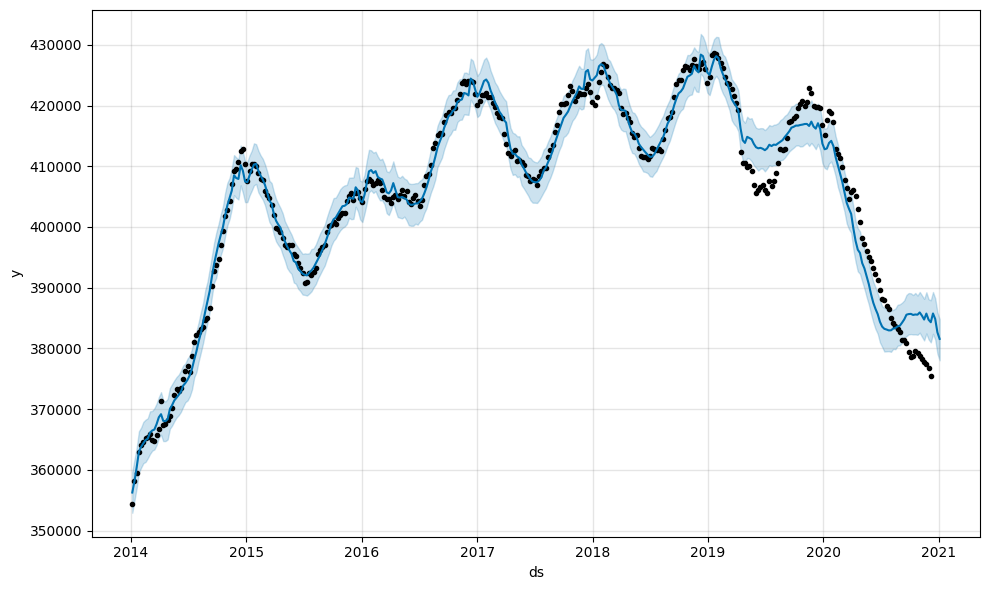

In [17]:
#Plot forecast
m.plot(forecast);

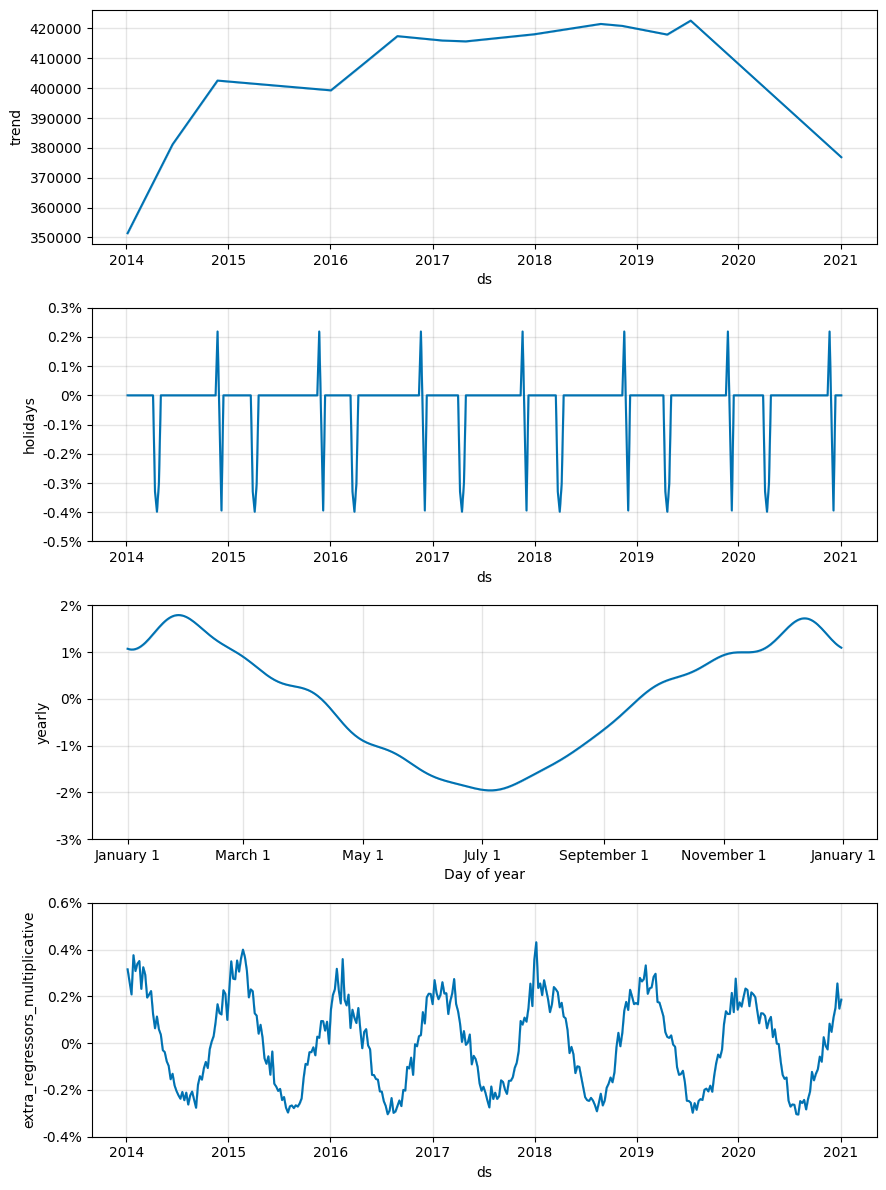

In [18]:
#model components
m.plot_components(forecast);

#Cross-Validation

In [19]:
#How many weeks of data we have
df.shape

(366, 4)

In [20]:
#CV
df_cv = cross_validation(m,
                         horizon = "4 W", # 28 days also possible
                         initial = "300 W", # 1500 days
                         parallel = 'processes')

INFO:prophet:Making 29 forecasts with cutoffs between 2019-10-13 00:00:00 and 2020-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7dedc4df2f20>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vdj50zg/mu57006o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vdj50zg/88vu1csm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vdj50zg/s5a31k4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vdj50zg/tl_niwv4.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11982', 'data', 'file=/tmp/tmp3vdj50zg/mu57006o.json', 'init=/tmp/tmp3vdj50zg/s5a31k4x.json', 'output', 'file=/tmp/tmp3vdj50zg/prophet_model_nilydtd/prophet_model-20230901095714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:idx 0
09:57:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [

In [21]:
#CV output
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-20,419446.086800,418056.752710,420752.419431,420265,2019-10-13
1,2019-10-27,420167.764136,418844.881264,421425.326020,420670,2019-10-13
2,2019-11-03,420736.400484,419324.004466,422048.748234,419924,2019-10-13
3,2019-11-10,420920.578344,419474.180739,422414.247466,420624,2019-10-13
4,2019-11-03,420677.018323,419213.270735,422053.318848,419924,2019-10-27
...,...,...,...,...,...,...
111,2020-11-22,392528.270301,389008.877545,395820.541216,377413,2020-10-25
112,2020-11-15,389183.307260,385681.288509,392513.828262,377700,2020-11-08
113,2020-11-22,390661.150493,387054.357780,394032.821534,377413,2020-11-08
114,2020-11-29,389686.167215,386192.809580,393317.217122,376769,2020-11-08


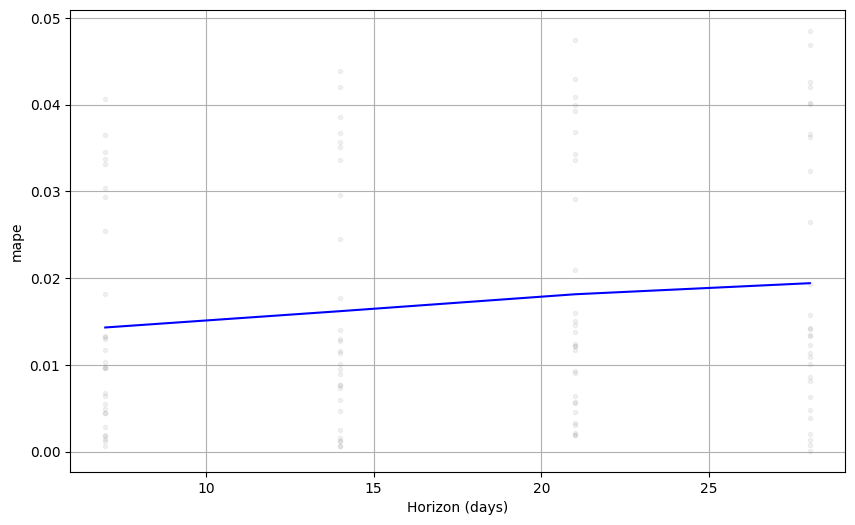

In [22]:
#CV visualization
plot_cross_validation_metric(df_cv, metric = "mape");

#Parameter Tuning

In [23]:
#Parameter Grid
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

54

In [24]:
#Parameter list
rmse = []

#Loop
for params in grid:
  #build the model
  m = Prophet(growth = 'linear',
              yearly_seasonality = True,
              weekly_seasonality = False,
              holidays = holidays,
              seasonality_mode = params['seasonality_mode'],
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale= params['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.add_regressor('Temperature')
  m.fit(training)

  #CV
  df_cv = cross_validation(m,
                          horizon = "4 W", # 28 days also possible
                          initial = "300 W", # 1500 days
                          parallel = 'processes')

  #Measure and store the error
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
  rmse.append(error)

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vdj50zg/mznj6e4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vdj50zg/4sm16rjk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34660', 'data', 'file=/tmp/tmp3vdj50zg/mznj6e4x.json', 'init=/tmp/tmp3vdj50zg/4sm16rjk.json', 'output', 'file=/tmp/tmp3vdj50zg/prophet_model1svbjxra/prophet_model-20230901100701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vdj50zg/8f9

In [25]:
#get the best parameters
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,9059.021025
1,0.01,5,additive,10,9076.092696
2,0.01,5,additive,20,9106.839260
3,0.01,5,multiplicative,5,8948.491857
4,0.01,5,multiplicative,10,9012.177870
5,0.01,5,multiplicative,20,8962.158162
6,0.01,10,additive,5,9088.853855
7,0.01,10,additive,10,9126.490148
8,0.01,10,additive,20,9085.282223
9,0.01,10,multiplicative,5,8929.634015
